# Logistic Regression: Goldie Versus The World

As I've been learning more about different types of models, I thought, why not try to see how I can use logistic regression to classify my dear cat Goldie. I have hundreds of photos of Goldie on my phone, surely enough to train a model and do some binary classification with. Without further ado, let's get into it!

In [4]:
# Load packages
import numpy as np
from proj_fcns import sigmoid, initialize_parameters, plot_costs
import os
import matplotlib.pyplot as plt
from PIL import Image

### Data set up
Let's begin by creating our dataset. I already have two folders that contain ~400 images of goldie and 400 random images I collected from Upsplash using their API (see guthub for image collection process).

Since I have all the images I want to use, I want to bring them in as arrays where each RGB value is recorded for each pixel for every images. I then want to assign the label 1 to all my Goldie images and 0 to all the random non-Goldie images. 

I'm also going to crop every images so the aspect ratio is consistant (don't want the images to look stretched or squished) and divide each images into 128 by 128 pixels.

In [5]:
def load_images(folder, label, img_size=(128, 128)):
    """
    Loads images from a folder and assigns them a label.

    Parameters:
        folder (str): Directory containing images.
        label (0 or 1): Label assigned to each image.
        img_size (tuple): dimentions to resize images (width, height). Default is (128, 128).

    Returns:
        tuple: Lists of preprocessed images and their labels.
    """
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('RGB')  # Convert to RGB
            
            # Crop the image to a square
            width, height = img.size
            if width != height:
                if width > height:
                    left = (width - height) // 2
                    right = left + height
                    top = 0
                    bottom = height
                else:
                    top = (height - width) // 2
                    bottom = top + width
                    left = 0
                    right = width
                img = img.crop((left, top, right, bottom))
            
            # Resize the image to the desired size
            img = img.resize(img_size)
            
            img_array = np.array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

base_path = os.getcwd()

# Construct the relative path to the images folder
cat_folder = os.path.join(base_path, "images", "goldie_pics")
not_cat_folder = os.path.join(base_path, "images", "random_pics")

# Load images
cat_images, cat_labels = load_images(cat_folder, 1)
not_cat_images, not_cat_labels = load_images(not_cat_folder, 0)

# Combine the datasets
all_images = np.array(cat_images + not_cat_images)
all_labels = np.array(cat_labels + not_cat_labels)

# Shuffle the dataset
shuffle_indices = np.random.permutation(len(all_labels))
all_images = all_images[shuffle_indices]
all_labels = all_labels[shuffle_indices]

# Split into training and testing sets (80% train, 20% test)
split_index = int(0.8 * len(all_labels))
train_images = all_images[:split_index]
train_labels = all_labels[:split_index]
test_images = all_images[split_index:]
test_labels = all_labels[split_index:]

# Reshape
train_images_flatten = train_images.reshape(train_images.shape[0], -1).T
test_images_flatten = test_images.reshape(test_images.shape[0], -1).T

# Standardize 
train_set = train_images_flatten / 255.
test_set = test_images_flatten / 255.


## Test images
To make sure the images look good loaded in, let's just take a quick look at a few examples to see what we're working with

y = 1, Yay it's Goldie!!


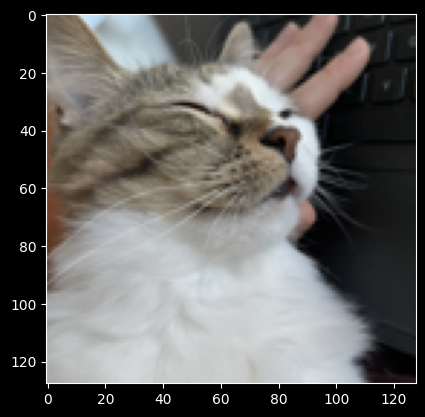

In [7]:
index = 2 # Change index to see what different pics are in the dataset!
plt.imshow(train_images[index])

if train_labels[index] == 1:
    result = "Yay it's Goldie!!"
else:
    result = "Boo, not a Goldie pic"

print ("y = " + str(train_labels[index]) + ", " + result)


### Reshape and standardize
Now let's do some organization. We want a 2D array so let's reshape and standardize our data. To standardize, I'm dividing by 255 since the RGB values range from 0 to 255.

In [8]:

# Reshape
train_images_flatten = train_images.reshape(train_images.shape[0], -1).T
test_images_flatten = test_images.reshape(test_images.shape[0], -1).T

# Standardize 
train_set = train_images_flatten / 255.
test_set = test_images_flatten / 255.


### Propogation
Now I want to compute the cost function and gradients using forward and backward propogation.

I'm going to use regularization for this to prevent overfitting. Without regularization, both the training and test accuracy of the model was ~15% less accurate! A model that can only detect a goldie image two thirds of the time is not *that* much better than random chance!

I'm choosing to use L1 regularization (Lasso Regression) with the idea that the pixels on the outside of the image should not have as much impact on image classification as the images near the centre of the image. I believe most images of Goldie shoud be (at least somewhat) centred. 

This means the cost function is going to look a little different - there's an added term at the end which adds the sum of the absolute value of the weights to the cost function. Here's what the cost function now looks like:

$$
J(w, b) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log(a^{(i)}) - (1 - y^{(i)}) \log(1 - a^{(i)}) \right] + \frac{\lambda}{m} \sum_{j=1}^{n} |w_j|

$$

Also note the sigmoid function $\sigma (z) = \frac{1}{1 + e^{-z}}$ for $z = w^T x + b$ is used to map the values between 0 and 1 so the results can be interpreted as a probability

In [9]:

def propagate(w, b, X, Y, lambda_reg):
    """
    Implements forward and backward propagation for the model.

    Parameters:
        w (ndarray): Weights, shape (dim, 1).
        b (float): Bias.
        X (ndarray): Input data, shape (dim, number of examples).
        Y (ndarray): True labels, shape (1, number of examples).
        lambda_reg (float): Regularization parameter.

    Returns:
        tuple: Gradients (dict with "dw" and "db") and cost.
    """
    m = X.shape[1]
    
    # Forward propagation
    A = sigmoid(np.dot(w.T, X) + b)
    
    # Add epsilon to avoid log(0) issues
    epsilon = 1e-10
    A = np.clip(A, epsilon, 1 - epsilon)
    
    # Cost function
    cost = (-1/m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))
    cost += (lambda_reg / m) * np.sum(np.abs(w))  # L1 Regularization term
    
    # Backward propagation
    dw = (1/m) * np.dot(X, (A - Y).T) + (lambda_reg / m) * np.sign(w)  # L1 Regularization term
    db = (1/m) * np.sum(A - Y)
    
    # Clip gradients to avoid massive gradients
    dw = np.clip(dw, -1, 1)
    db = np.clip(db, -1, 1)
    
    cost = np.squeeze(cost)
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

### Optimization
The aim is to minimize the cost function

To do this, the propogation function defined above is used to get the current gradients for the weights (dw) and bias (db). These values are used in gradient descent to calculate the cost. With each iteration, weights and bias will get updated to minimize the cost.

In [10]:

def optimize(w, b, X, Y, num_iterations, learning_rate, lambda_reg, print_cost=False):
    """
    Optimizes parameters using gradient descent.

    Parameters:
        w (ndarray): Weights, shape (dim, 1).
        b (float): Bias.
        X (ndarray): Input data, shape (dim, number of examples).
        Y (ndarray): True labels, shape (1, number of examples).
        num_iterations (int): Number of iterations for optimization.
        learning_rate (float): Learning rate for gradient descent.
        lambda_reg (float): Regularization parameter.
        print_cost (bool): If True, prints cost every 100 iterations. Default is False.

    Returns:
        tuple: Optimized parameters (dict with "w" and "b"), gradients (dict with "dw" and "db"), and list of costs.
    """
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y, lambda_reg)
        
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        if i % 100 == 0 or i == num_iterations - 1:
            costs.append(cost)
        if print_cost and (i % 100 == 0 or i == num_iterations - 1):
            print(f"Cost after iteration {i}: {cost}")
    
    params = {"w": w, "b": b}
    grads = {"dw": dw, "db": db}
    
    return params, grads, costs
    

### Make Predictions

The follow function will be used to make the predictions - if we get a value over 0.5 then an image of Goldie is predicted! Otherwise it's predicted to be a random, non-goldie image.

In [11]:

def predict(w, b, X):
    """
    Predicts labels for input data using learned parameters.

    Parameters:
        w (ndarray): Weights, shape (dim, 1).
        b (float): Bias.
        X (ndarray): Input data, shape (dim, number of examples).

    Returns:
        ndarray: Predicted labels, shape (1, number of examples).
    """
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
    
    return Y_prediction

### Train the model

In [12]:

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, lambda_reg=0.1, print_cost=False):
    """
    Builds and trains a logistic regression model, then evaluates it on the test set.

    Parameters:
        X_train (ndarray): Training data, shape (dim, number of training examples).
        Y_train (ndarray): Training labels, shape (1, number of training examples).
        X_test (ndarray): Test data, shape (dim, number of test examples).
        Y_test (ndarray): Test labels, shape (1, number of test examples).
        num_iterations (int): Number of iterations for optimization. Default is 2000.
        learning_rate (float): Learning rate for gradient descent. Default is 0.5.
        lambda_reg (float): Regularization parameter. Default is 0.1.
        print_cost (bool): If True, prints cost every 100 iterations. Default is False.

    Returns:
        dict: Dictionary containing model information including costs, predictions, parameters, learning rate, number of iterations, and regularization parameter.
    """
    
    w, b = initialize_parameters(X_train.shape[0]) 
    
    parameters, _, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, lambda_reg, print_cost) # gradient dosn't need to be assigned
    
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)
    
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    d = {"costs": costs,
         "Y_prediction_train": Y_prediction_train, 
         "Y_prediction_test": Y_prediction_test, 
         "w": w, 
         "b": b,
         "learning_rate": learning_rate,
         "num_iterations": num_iterations,
         "lambda_reg": lambda_reg}
    
    return d

# Results
I'm going to do 500 iterations to see how the model runs, and view the costs after every 100 iterations

Cost after iteration 0: 0.822744268820832
Cost after iteration 100: 0.5647021426770902
Cost after iteration 200: 0.4921741557579927
Cost after iteration 300: 0.4599870021959059
Cost after iteration 400: 0.4345841093435946
Cost after iteration 500: 0.41335870093150545
Cost after iteration 600: 0.39505580789617306
Cost after iteration 700: 0.3789351433376338
Cost after iteration 800: 0.3645189600873074
Cost after iteration 900: 0.35147857389840276
Cost after iteration 1000: 0.33957722541543606
Cost after iteration 1100: 0.3286380869925891
Cost after iteration 1200: 0.3185246844391773
Cost after iteration 1300: 0.3091294816354887
Cost after iteration 1400: 0.3003659640607931
Cost after iteration 1500: 0.29216301085554375
Cost after iteration 1600: 0.2844613491754766
Cost after iteration 1700: 0.2772112968628913
Cost after iteration 1800: 0.2703701289542386
Cost after iteration 1900: 0.2639011537618683
Cost after iteration 2000: 0.2577723281083276
Cost after iteration 2100: 0.2519554926272

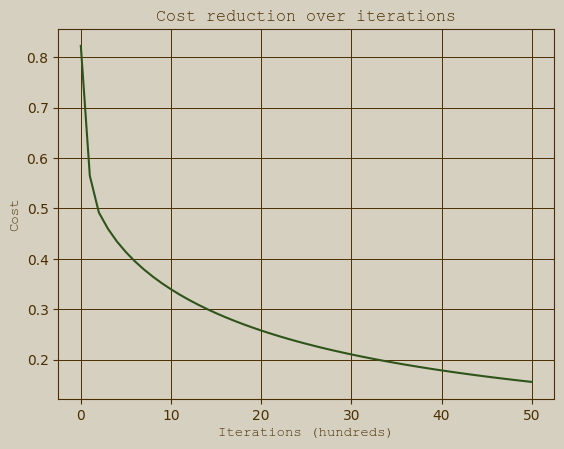

In [13]:
# Reshape labels 
train_labels = train_labels.reshape(1, -1)
test_labels = test_labels.reshape(1, -1)

# Train the model
d = model(train_set, train_labels, test_set, test_labels, num_iterations=5000, learning_rate=0.001, lambda_reg=0.01, print_cost=True)

# Plot the costs
plot_costs(d["costs"])


# Conclusion

Cost after iteration 4999: 0.15570564061677383

train accuracy: 97.70642201834862 %

test accuracy: 79.8780487804878 %

Nearly 80%, not too bad! Before adding in the regularization term, the test accuracy was a grim 65% so this is looking much nicer. I found of all the things I added to the simplist version of a logistric regression model, the regulairization term improved the accuracy the most.